# 09. PyTorch Model Deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning models(s) available to someone or something else.

### 0. Get setup

## 1. Getting Data

The dataset we're going to use for deploy a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% images)

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (4056/4056), done.
remote: Compressing objects: 100% (1626/1626), done.
remote: Total 4056 (delta 2387), reused 3946 (delta 2369), pack-reused 0
Receiving objects: 100% (4056/4056), 649.87 MiB | 34.71 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

test_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/test'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline


### 3. Questions
1. What is my most ideal machine learning deploy scenatio?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.
* Performs well: 95%+ accuracy
* Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency [1sec/30] )
  * Latency = time for prediction to take place

To try and achive these goals, we're goign to build two model experiments:

1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)



## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to our certain problem.

EffNetB2 pretrained model in PyTorch: https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2

In [5]:
import torchvision
torchvision.__version__

'0.16.2'

In [6]:
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [7]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 69.3MB/s]


In [8]:
from torchinfo import summary

# Print summary of EffNetB2 model
summary(model=effnetb2,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [9]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [10]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True))

In [11]:
summary(model=effnetb2,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [12]:
def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1,2,3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head wight random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [13]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [14]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [15]:
summary(model=effnetb2,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.3 Creating DataLoaders for EffNetB2

In [16]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [17]:
print("--- effnetb2 ---")
print(f"Train DataLoaders: - {len(train_dataloader_effnetb2)}")
print(f"Test DataLoaders: -- {len(test_dataloader_effnetb2)}")
print(f"Class names: ------- {class_names}")

--- effnetb2 ---
Train DataLoaders: - 15
Test DataLoaders: -- 5
Class names: ------- ['pizza', 'steak', 'sushi']


### 3.3 Training EffnetB2 feature extractor

In [18]:
!nvidia-smi

Fri Feb 16 19:51:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              30W / 250W |    412MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
from going_modular.going_modular import engine

LEARNING_RATE = 1e-3
EPOCHS = 10

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=LEARNING_RATE)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=EPOCHS,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9844 | train_acc: 0.5667 | test_loss: 0.7411 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7172 | train_acc: 0.8396 | test_loss: 0.5878 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5879 | train_acc: 0.8938 | test_loss: 0.4901 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4481 | train_acc: 0.9125 | test_loss: 0.4349 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4302 | train_acc: 0.9062 | test_loss: 0.3921 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4400 | train_acc: 0.8875 | test_loss: 0.3523 | test_acc: 0.9597
Epoch: 7 | train_loss: 0.4253 | train_acc: 0.8792 | test_loss: 0.3267 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3900 | train_acc: 0.8979 | test_loss: 0.3462 | test_acc: 0.9352
Epoch: 9 | train_loss: 0.3770 | train_acc: 0.8771 | test_loss: 0.3130 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3769 | train_acc: 0.8625 | test_loss: 0.2814 | test_acc: 0.9688


### 3.4 Inspecting EffNetB2 loss curves

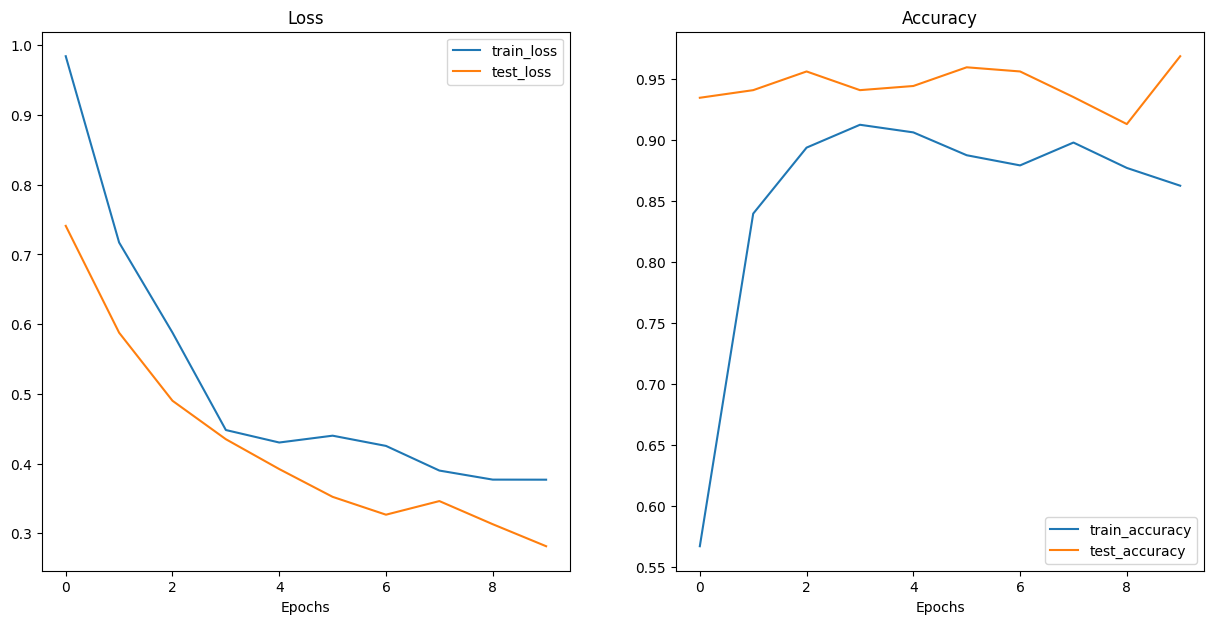

In [20]:
plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 fature extractor

In [21]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor

In [22]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)

print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size,2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [23]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [24]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss":effnetb2_results["test_loss"][-1],
                  "test_acc":effnetb2_results["test_acc"][-1],
                  "number_of_parameters":effnetb2_total_params,
                  "model_size (MB)":pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.28142198324203493,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

## 4. Creating ViT feature extractor

In [25]:
# Check out the ViT heads layers
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [26]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all of the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head to suit our needs
  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768,
                                        out_features=num_classes))

  return model, transforms

In [27]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 247MB/s]  


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [28]:
summary(model=vit,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT feature extractor

In [29]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup

BATCH_SIZE = 32

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=BATCH_SIZE)

print("--- ViT ---")
print(f"Train DataLoaders: - {len(train_dataloader_vit)}")
print(f"Test DataLoaders: -- {len(test_dataloader_vit)}")
print(f"Class names: ------- {class_names}")

--- ViT ---
Train DataLoaders: - 15
Test DataLoaders: -- 5
Class names: ------- ['pizza', 'steak', 'sushi']


### 4.2 Training ViT Feature Extractor

In [30]:
from going_modular.going_modular import engine

LEARNING_RATE = 1e-3
EPOCHS = 10

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=LEARNING_RATE)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT feature extractor with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           loss_fn=loss_fn,
                           epochs=EPOCHS,
                           optimizer=optimizer,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT feature extractor

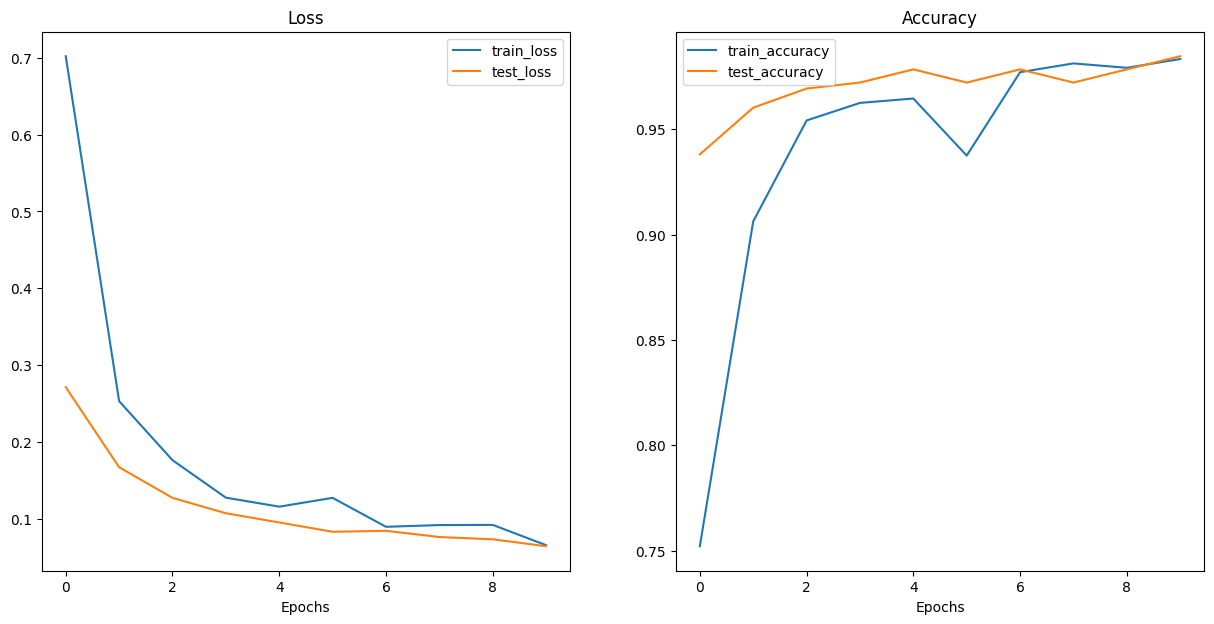

In [31]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [32]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


## 4.5 Checking the size of ViT feature extractor

In [33]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)

print(f"Pretrained ViT feature extractor model size: {round(pretrained_vit_model_size,2)} MB")

Pretrained ViT feature extractor model size: 327.37 MB


### 4.6 Collecting a Vit feature extractor stats

In [34]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [35]:
print(f"Count number of total parameters in ViT \t{vit_total_params}")
print(f"Count number of total parameters in EffNetB2 \t{effnetb2_total_params}")

Count number of total parameters in ViT 	85800963
Count number of total parameters in EffNetB2 	7705221


In [36]:
# Create a dictionary with vit statistics
vit_stats = {"test_loss":vit_results["test_loss"][-1],
                  "test_acc":vit_results["test_acc"][-1],
                  "number_of_parameters":vit_total_params,
                  "model_size (MB)":pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443451130762697,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887}

### 5. Making predictions with trained models and timing

Goal is:
1. Perform well (95%+ test accuracy)
2. Is fast (30+FPS)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image

Let's work towards making a function called `pred_and_store()` to do so.

First we'll need a list of test image paths

In [37]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1683426.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1600999.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/472912.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2903125.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2274102.jpg')]

### 5.1 Creating a function to make predictions across the test dataset

Steps to create `pred_and_store()`:

1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and target device.
2. Creat an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (predictions statistics will go in here).
5. Get the sample path and ground thuth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model (also add batch dimension and send to target device.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calclate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.

In [38]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

from typing import List, Dict

# 1.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names:List[str],
                   device:str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  # 2.
  pred_list = []

  # 3.
  for path in tqdm(paths):

    # 4.
    pred_dict = {}

    # 5.
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6.
    start_time = timer()

    # 7.
    img = Image.open(path)

    # 8.
    transformer_image = transform(img).unsqueeze(0).to(device)

    # 9.
    model = model.to(device)
    model.eval()

    # 10.
    with torch.inference_mode():
      pred_logit = model(transformer_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probability into prediction label
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python variables live on CPU)

      # 11.
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12.
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time - start_time, 4)

    # 13.
    pred_dict["correct"] = class_name == pred_class

    # 14.
    pred_list.append(pred_dict)

  # 15.
  return pred_list

### 5.2 Making and timing with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:
1. Device - we're going to hardcode our predictions to happen on CPU (becouse you won't always be sure of having a GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropirate transforms (e.g. EffNetB2 with effnetb2_transforms)

In [39]:
# Make a prediction test dataset with EffNetB2

effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                         model=effnetb2,
                                         transform=effnetb2_transforms,
                                         class_names=class_names,
                                         device="cpu") #hardcode predictions to happen on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [40]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1683426.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.6195,
  'pred_class': 'sushi',
  'time_for_pred': 0.2079,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1600999.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9548,
  'pred_class': 'sushi',
  'time_for_pred': 0.0868,
  'correct': True}]

In [41]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.6195,sushi,0.2079,True
1,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9548,sushi,0.0868,True
2,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.6793,sushi,0.0754,True
3,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.8012,sushi,0.0833,True
4,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.6035,sushi,0.0786,True


In [42]:
# Chck number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     145
False      5
Name: count, dtype: int64

In [43]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(),4)
print(f"EffNetB2 averange time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 averange time per prediction: 0.0858


> **Note:** Prediction times will vary (much like training times) depending on the hardware you're using... so generally the faster your compute (e.g. CPU or GPU), the faster the prediction will happen

In [44]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28142198324203493,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166,
 'time_per_pred_cpu': 0.0858}

### 5.3 Making and timing predictions with ViT

In [45]:
# Make list of prediction dictionaries with ViT feature extractor model on test images

In [46]:
# Make a prediction test dataset with ViT

vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                         model=vit,
                                         transform=vit_transforms,
                                         class_names=class_names,
                                         device="cpu") #hardcode predictions to happen on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [47]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.7384,sushi,0.4245,True
1,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9945,sushi,0.2105,True
2,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.8480,sushi,0.2039,True
3,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9975,sushi,0.2079,True
4,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9843,sushi,0.2035,True


In [48]:
# Chck number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [49]:
# Find the average time per prediction
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(),4)
print(f"ViT averange time per prediction: {vit_average_time_per_pred}")

ViT averange time per prediction: 0.2415


In [50]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443451130762697,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887,
 'time_per_pred_cpu': 0.2415}

## 6. Comparing model results, prediction times and size


In [51]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

# Rount size (MB)
df["model_size (MB)"] = round(df["model_size (MB)"],2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281422,96.88,7705221,29.86,0.0858,EffNetB2
1,0.064435,98.47,85800963,327.37,0.2415,ViT


Which model is better??

* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better*) - if model has more parameters, it generally takes longer to computer
    * *sometimes models with higher parameters can still perform fast
* `model_size (MB)` - EffNetB2 (for our case of deployment to a mobile device, generally lower is better)
* `time_per_pred_cpu` - (lower is better, will be highly dependet on the hardware you're running on) - EffNetB2

Both models fail to achive our goal of 30+FPS... however we could always just try and use EffNetB2 and see how it goes.

In [52]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T


,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.22896,1.016412,11.135432,10.963496,2.814685


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 onad ViT feature extractor models, now let's visualize the comparasion with a speed vs. performance plot

We can do so with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model sizes (model_size (MB)).

In [53]:
import matplotlib
matplotlib.__version__

'3.7.4'

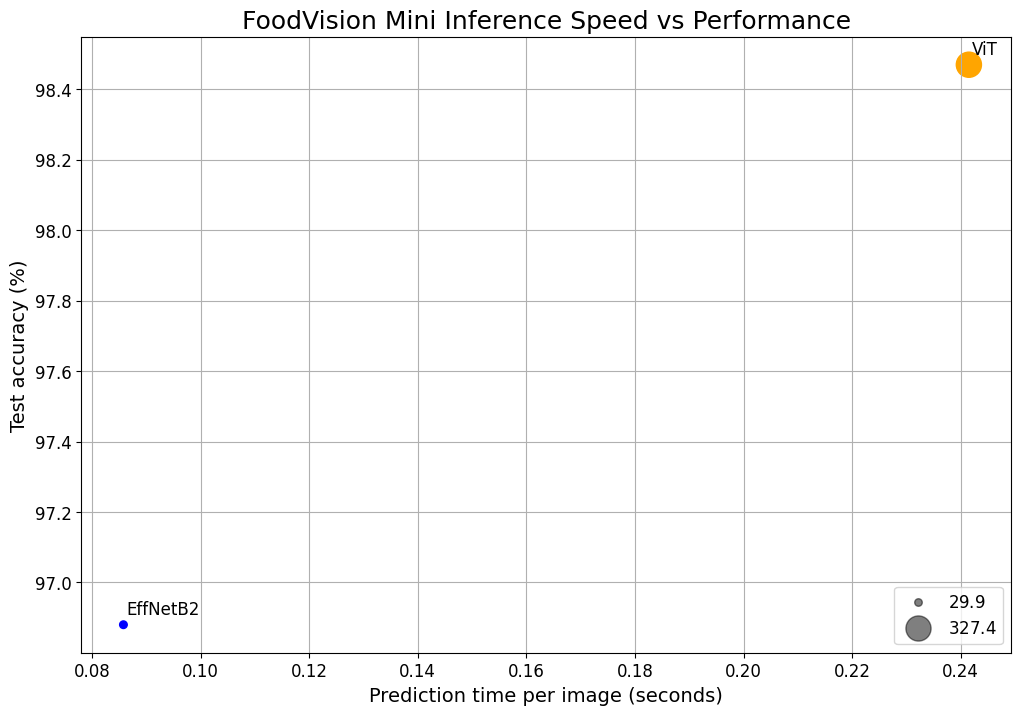

In [54]:
# 1. Create a plot from model comparision DataFrame
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df,
                    x="time_per_pred_cpu",
                    y="test_acc",
                    c=["blue", "orange"],
                    s="model_size (MB)")

# 2. Add titles and labels to make our plot look good
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot so we know what's going on.
for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on the model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                            labels,
                            loc="lower right",
                            fontsize=12)

# Save the figure
plt.savefig("09_foodvision_mini_inference_speed_vs_performance.png")

## 7. Bringing FoodVision Mini to life by creating Gradio demo

We've chosen to deploy EffNetB2 as it fulfils our criteria the best.

https://gradio.app/


In [55]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 4.19.0


### 7.2 Create a function to map our inputs and outputs

In [56]:
# Put our model to the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
images of food -> ML model (EffNetB2) -> outputs (food class label, prediction time)
```

In [57]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    # Start a timer
    start_time = timer()

    # Transform the input image for use with EffNetB2
    img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension of 0th index

    # Put model into eval mode, make prediciton
    effnetb2.eval()
    with torch.inference_mode():
        # Pass transformed image through the model and turn the prediction logits into probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary
    pred_labels_and_probs = {class_names[i]:float(pred_probs[0][i]) for i in range (len(class_names))}

    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time-start_time,4)

    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time

In [58]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
print(f"Example test data path: {test_data_paths[0]}")

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)


Example test data path: data/pizza_steak_sushi_20_percent/test/sushi/1683426.jpg
[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/720302.jpg

{'pizza': 0.3244290351867676, 'steak': 0.21413558721542358, 'sushi': 0.46143537759780884}
0.0858


### 7.3 Creating a list of example images

The examples for Gradio can be created with the `examples` parameter, see here https://www.gradio.app/docs/interface

In [59]:
# Create list of example inputs to Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/804460.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg']]

### 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, prob, time
```

In [60]:
import gradio as gr

# Lekcja 303

# Create title, description and article
title = "FoodVision Mini 🍕🍣🥩"
description = "First ever model by me with EfficientNetB2 feature extractor to classify images as pizza, steak, sushi."
article = "Creating at 16.02.2024 with assistance of PyTorch course"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs and outputs
                   inputs=gr.Image(type="pil"),
                   outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                           gr.Number(label="Prediction time (s)")],
                   examples=example_list,
                   title=title,
                   description=description,
                   article=article)

# Launch the demo
# demo.launch(debug=False, # print errors localy?
#            share=True) # generate a publically sharable URL

## 8. Turning our FoodVision Mini Gradio Dmo into a deployable app

### Deployed gradio app structure

Let's start to puit all of app files into a single directory:

```
Colab -> folder with all Gradio files -> upload app filest to Hugging Face Spaces -> deploy
```

By the end our file structiure will look like this:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```


### 8.3 Creating a `demos` folder to store our FoodVision app files

In [61]:
import shutil
from pathlib import Path

# Create FoodVIsion mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files in that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path) # if something exist, delete it and start refreshed
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)

  !ls demos/foodvision_mini/

### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
* 3 images in an `examples/` directory
* Images should be from the test set

In [62]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True,
                                    exist_ok=True)

# Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy the three images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example,
               dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Let's now verify that we can get a list of lists from our `examples/` directory

In [63]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/592799.jpg'], ['examples/3622237.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision MIni demo directory

In [64]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]
# effnetb2_foodvision_mini_model_destination

# Try to move the model file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the model
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)

  print(f"[INFO] Model move complete.")
# If the model has already been moved, check if it exists
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning off EffNetB2 model into a Python scrpit (`model.py`)

In [65]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1,2,3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head wight random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

Writing demos/foodvision_mini/model.py


### 8.7 Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

The `app.py` file will have four major parts.
1. Imports and class names setup
2. Model and transforms preparations
3. Predict function (`predict()`)
4. Gradio app - our Gradio interface + launch command

In [66]:
%%writefile demos/foodvision_mini/app.py

### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dictionary

class_names = ["pizza","steak","sushi"]


### 2. Model and transforms preparation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu") # load the model to the CPU
    )
)


### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
    # Start a timer
    start_time = timer()

    # Transform the input image for use with EffNetB2
    img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension of 0th index

    # Put model into eval mode, make prediciton
    effnetb2.eval()
    with torch.inference_mode():
        # Pass transformed image through the model and turn the prediction logits into probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary
    pred_labels_and_probs = {class_names[i]:float(pred_probs[0][i]) for i in range (len(class_names))}

    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time-start_time,4)

    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time


### 4. Gradio app ###

# Create title, description and article
title = "FoodVision Mini 🍕🍣🥩"
description = "First ever model by me with EfficientNetB2 feature extractor to classify images as pizza, steak, sushi."
article = "Creating at 16.02.2024 with assistance of PyTorch course"

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs and outputs
                   inputs=gr.Image(type="pil"),
                   outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                           gr.Number(label="Prediction time (s)")],
                   examples=example_list,
                   title=title,
                   description=description,
                   article=article)

Launch the demo
demo.launch(debug=False)

Writing demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for FoodVision Mini (`requirements.txt`)

The requirements file will tell our Hugging Face Space what software dependencies our app requires.

The three main ones are:
* `torch`
* `torchvision`
* `gradio`

In [67]:
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Gradio version: {gr.__version__}")

Torch version: 2.1.2
Torchvision version: 0.16.2
Gradio version: 4.19.0


In [68]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.1.2
torchvision==0.16.2
gradio==4.19.0

Writing demos/foodvision_mini/requirements.txt


## 9. Deploy FoodVision Mini app HuggingFace Spaces

### 9.1 Downloading FoodVision mini app files

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face Spaces

In [69]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
examples
model.py
requirements.txt


In [70]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*.__pycache__*" "*ipynb_checkspoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: examples/ (stored 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 45%)
  adding: requirements.txt (deflated 4%)


In [71]:
# Download
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print(f"Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_mini.zip manually")

Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_mini.zip manually


### 9.2 Running Gradio app locally

Here: https://www.learnpytorch.io/09_pytorch_model_deployment/#92-running-our-foodvision-mini-demo-locally

### 9.3 Uploading FoodVision Mini Gradio demo to Hugging Face Spaces

Here: https://www.learnpytorch.io/09_pytorch_model_deployment/#93-uploading-to-hugging-face

### 9.4 Launch FoodVision Mini in notebook

In [72]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embeded FoodVision Mini Gradio demo
IFrame(src="https://huggingface.co/spaces/DarekW90/foodvision_mini_course", width=900, height=750)

## 10. Creating FoodVision Big!!

FoodVision Mini works with 3 classes

So all of experimenting is paying off...

Let's step things up a notch and make FoodVision BIG! Using all Food101 classes.

### 10.1 Creating a model FoodVision Big + Transforms

In [73]:
# Create Food101 model and transfoms

effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [74]:
from torchinfo import summary

# Print EffNetB2 model summary
summary(effnetb2_food101,
       input_size=(1,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we're working with a larger dataset, we may want to introduce some data augumentation techniques:
* This is becouse with larger datasets and larger models, overfitting becomes more of a problem.
* Becouse we're working with a large number of classes, let's use TrivialAugument as our data augumentation technique

In [75]:
# Create training data transforms

food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [76]:
# Testing data transform
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 10.2 Getting data for FoodVision Big

In [77]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get the training data (~750 x 101 classes = 100000 images)
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms, # apply data augmentation to training data
                              download=True)

# Get the testing data
test_data = datasets.Food101(root=data_dir,
                            split="test",
                            transform=effnetb2_transforms, # don't perform data augmentation on the test data
                            download=True)

100%|██████████| 4996278331/4996278331 [04:37<00:00, 17981970.69it/s]


Extracting data/food-101.tar.gz to data


In [78]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 dataset for faster experimenting

Why to create a subset?

We want to our first few experiments to run as quick as possible.

To do so, let's make a subset of 20% of the data from the Food101 dataset (training and test).

Our short-term goal: to beat the original Food101 paper results of 56.40% accuracy on the test dataset (see paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

We want to beat this results using modern deep learning trechniques and only 20% of the data.

In [79]:
len(train_data) * 0.2, len(test_data) * 0.2

(15150.0, 5050.0)

In [80]:
from torch.utils.data import random_split # https://pytorch.org/docs/stable/data.html

def split_dataset(dataset:torchvision.datasets,
                 split_size:float=0.2,
                 seed:int=42):
    # Create split lenghts based on original dataset lenght
    length_1 = int(len(dataset) * split_size) # defaults to 20% data split
    length_2 = len(dataset) - length_1 # remening lenght
    
    # Print out info
    print(f"[INFO] Splitting dataset of lenght {len(dataset)} into splits of size: {length_1} and {length_2}")
    
    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                  lengths=[length_1, length_2],
                                                                  generator=torch.manual_seed(seed))
    
    return random_split_1, random_split_2

In [81]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                             split_size=0.2)

# Create testing 20% split Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                            split_size=0.2)

[INFO] Splitting dataset of lenght 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of lenght 25250 into splits of size: 5050 and 20200


In [82]:
len(test_data_food101_20_percent), len(test_data_food101_20_percent)

(5050, 5050)

### 10.4 Turning Food101 datasets into `DataLoader`s

In [83]:
import os 

os.cpu_count()

4

In [84]:
import torch
import os

BATCH_SIZE = 32
NUM_WORKERS = 2

# Create Food101 20 training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=True,
                                                                 num_workers=NUM_WORKERS)

# Create Food101 20% testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False,
                                                                num_workers=NUM_WORKERS)

In [85]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

### 10.5 Training FoodVision Big!

Things for training:
* 5 epochs
* Optimizer: `torch.optim.Adam(lr=1e-3)`
* Loss function: `torch.nn.CrossEntropyLoss(label_smoothing=0.1) https://paperswithcode.com/method/label-smoothing`

Why use label_smoothing?
Label smoothing helps to prevent overfitting (it's a regularization technique).

Without label smoothing and 5 classes

```
[0.00, 0.00, 0.99, 0.01, 0.00]
```

With label smoothing and 5 classes

```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

In [86]:
!nvidia-smi

Fri Feb 16 20:00:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              31W / 250W |   1190MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [87]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                            lr=1e-3)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 paper's results of 56,4% accuracy on the test dataset with 20% of the data
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                       train_dataloader=train_dataloader_food101_20_percent,
                                       test_dataloader=test_dataloader_food101_20_percent,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       epochs=5,
                                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6414 | train_acc: 0.2810 | test_loss: 2.7818 | test_acc: 0.4897
Epoch: 2 | train_loss: 2.8613 | train_acc: 0.4424 | test_loss: 2.4718 | test_acc: 0.5355
Epoch: 3 | train_loss: 2.6560 | train_acc: 0.4868 | test_loss: 2.3628 | test_acc: 0.5582
Epoch: 4 | train_loss: 2.5452 | train_acc: 0.5109 | test_loss: 2.3019 | test_acc: 0.5749
Epoch: 5 | train_loss: 2.4960 | train_acc: 0.5237 | test_loss: 2.2793 | test_acc: 0.5808


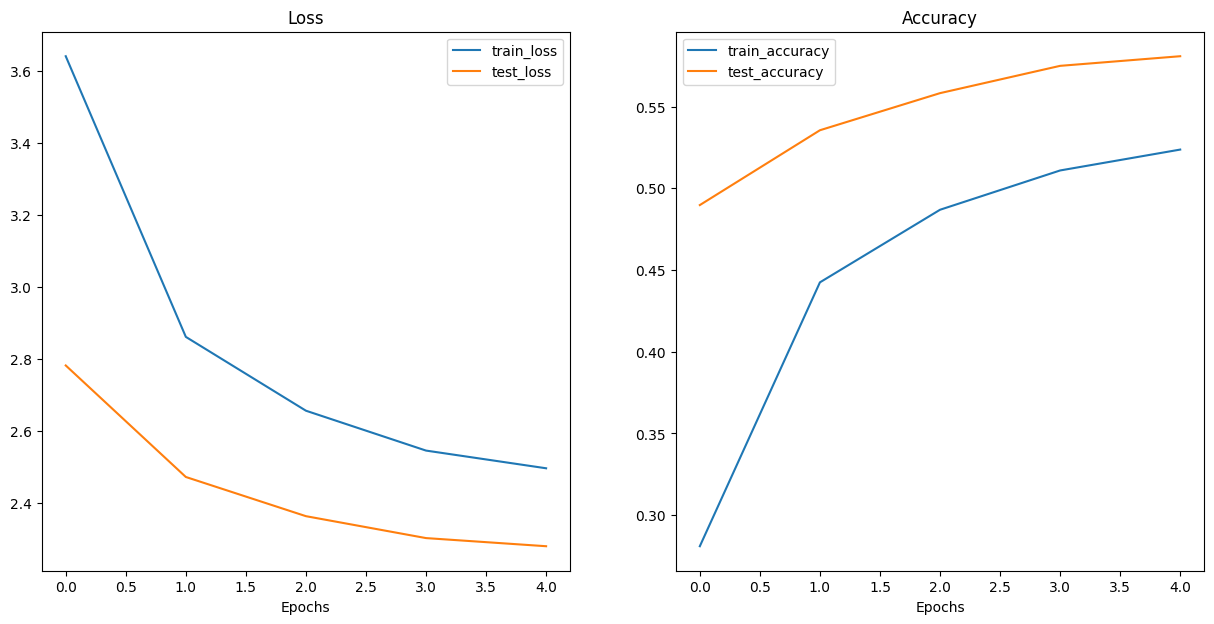

In [88]:
### 10.6 Inspecting loss curves of FoodVision Big model
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

In [102]:
### 10.7 Save and load FoodVision Big model
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [91]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

### 10.8 Checking FoodVision Big Model size

In [93]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractore Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractore Food101 model size: 30 MB


## 11. Turning FoodVision Big model into a deployable app

Let's create outline for FoodVision Big

```
demos/
    foodvision_big/
        09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
        app.py
        class_names.txt
        examples/
            example_1.jpg
        model.py
        requirements.txt
```

In [95]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True,
                              exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

### 11.1 Downloading an example image and moving it to the `examples` dirctory

In [101]:
# # Download and move example image
# !wget 
# !mv 

--2024-02-16 20:26:25--  https://t1.gstatic.com/licensed-image?q=tbn:ANd9GcRoeUqD7lgiXavof_C8DW2QeI-BHIzGPLKRPCWinurLGGMBT7GSml0le6bQro8yWjAa
Resolving t1.gstatic.com (t1.gstatic.com)... 172.253.117.106, 172.253.117.103, 172.253.117.147, ...
Connecting to t1.gstatic.com (t1.gstatic.com)|172.253.117.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 421288 (411K) [image/jpeg]
Saving to: 'licensed-image?q=tbn:ANd9GcRoeUqD7lgiXavof_C8DW2QeI-BHIzGPLKRPCWinurLGGMBT7GSml0le6bQro8yWjAa'

licensed-image?q=tb 100%[===================>] 411.41K  --.-KB/s    in 0.005s  

2024-02-16 20:26:25 (89.2 MB/s) - 'licensed-image?q=tbn:ANd9GcRoeUqD7lgiXavof_C8DW2QeI-BHIzGPLKRPCWinurLGGMBT7GSml0le6bQro8yWjAa' saved [421288/421288]



In [105]:
!mv /kaggle/working/models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth /kaggle/working/demos/foodvision_big

### 11.2 Saving Food101 class names to file (`class_names.txt`)

Let's save all of the Food101 class names to a .txt file so we can use it in our app

In [106]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [107]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [108]:
# Write Food101 class names to text file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # new line per class name

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [111]:
# Open Food101 class names file and reat each line into a list
with open(foodvision_big_class_names_path, "r") as f:
#     food101_class_names_loaded = [food for food in f.readlines()]
    food101_class_names_loaded = [food.strip() for food in f.readlines()]
    
food101_class_names_loaded

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

### 11.3 Turning our FoodVision Big model into a Python script (model.py)

In [112]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def creatre_effnetb2_model(num_classes:int=101,
                          seed:int=42):
    
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    for param in model.parameters():
        param.requires_grad = False
        
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True)
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    
    return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Python scrpit (`app.py`)

The `app.py` file will have four major parts:
1. Imports and class names setup -> for class names, we'll need to import from `class_names.txt` rather than with Python list
2. Model and transforms preparation -> we'll need to make sure our model is suitable for FoodVision Big
3. Predict function (`predict()`) -> this can stay the same as the original `predict()`
4. Gradio app - Gradio interface + launch command -> this will change slightly from FoodVision Mini to reflect the FoodVison Big updates

In [114]:
%%writefile demos/foodvision_big/app.py

# 1. Imports and class names setup
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_name.txt", "r") as f:
    class_names = [food_name.strip() for food_name in f.readlines()]
    
# 2. Model and transforms preparation
# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
              map_location=torch.device("cpu"))
)

# 3. Predict function
def predict(img) -> Tuple[Dict, float]:
    # Start timer
    start_time = timer()
    
    # Transform the input image for use with EffNetB2
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into eval mode, make prediction
    effnetb2.eval()
    
    with torch.inference_mode():
        # Pass transformed image through the model and turn the prediction logits into probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
        
    # Create a prediction label and prediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4)
    
    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time

# 4. Gradio app

# Create title, description and article
title = "FoodVision Big 🔥🔥🔥"
description = "TorchVision model with EfficientNetB2 feature extractor to classify all kind of foods from Food101 [dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)"
article = "Created at 16.02.2024 with assistance of PyTorch course"

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs and outputs
                   inputs=gr.Image(type="pil"),
                   outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                            gr.Number(label="Prediction time (s)")],
                   examples=example_list,
                   title=title,
                   description=description,
                   article=article)

# Launch the demo
demo.launch(debug=False)

Overwriting demos/foodvision_big/app.py


In [115]:
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Gradio version: {gr.__version__}")

Torch version: 2.1.2
Torchvision version: 0.16.2
Gradio version: 4.19.0


### 11.5 Creating a requirements file for FoodVision Big (`requirements.txt`)

In [116]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.1.2
torchvision==0.16.2
gradio==4.19.0

Writing demos/foodvision_big/requirements.txt


### 11.6 Downloading FoodVision Big

In [118]:
# Change into the foodvision_big directoryu and the zip it from the inside
!cd demos/foodvision_big && zip ../foodvision_big.zip * -x "*.pyc" "*__pychache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: model.py (deflated 49%)
  adding: requirements.txt (deflated 4%)


In [119]:
# Download
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print(f"Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_big.zip manually")

Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_big.zip manually
